In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# Load main dataset and cluster labels, then merge to create a dataframe with cluster assignments
import pandas as pd

main_data_path = '../data/raw_data/new_raw_data_polygon.csv'
cluster_labels_path = '../data/raw_data/interaction_mode_results/main_clustering/hdbscan_results/cluster_labels.csv'

# Load the main dataset
main_df = pd.read_csv(main_data_path)

# Load the cluster labels
main_cluster_labels = pd.read_csv(cluster_labels_path)

# Merge cluster labels with main dataset (on 'id' if present, else by index)
if 'id' in main_df.columns and 'id' in main_cluster_labels.columns:
    merged_main = pd.merge(main_df, main_cluster_labels, on='id', how='left')
else:
    merged_main = main_df.copy()
    merged_main['cluster_label'] = main_cluster_labels['cluster_label']

# merged_main now contains all data and their dedicated cluster labels

In [90]:
feature_analysis_results = {}
for cluster in sorted(merged_main['cluster_label'].dropna().unique()):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster]
    # Use the feature analysis function from interaction_mode_features_v2.py
    # Replace 'your_feature_analysis_function' with the actual function name
    # Example: result = interaction_mode_features_v2.analyze_features(cluster_df)
    # For demonstration, we'll just compute means for all numeric columns
    result = cluster_df.describe().T[['mean', 'std', 'min', 'max']]
    feature_analysis_results[cluster] = result
# Combine all results into a single DataFrame for easy comparison
combined_feature_analysis = pd.concat(feature_analysis_results, names=['cluster_label'])
combined_feature_analysis

mean           std    min  \
cluster_label                                                               
-1            TX_PER_MONTH                 19.100927  4.957916e+01   1.00   
              TOKEN_DIVERSITY               4.242555  2.560051e+00   1.00   
              PROTOCOL_DIVERSITY           10.772005  1.441968e+01   1.00   
              TOTAL_TRANSFER_USD       101970.263210  3.222417e+06   0.03   
              INTERACTION_DIVERSITY         9.119457  4.015523e+00   1.00   
...                                              ...           ...    ...   
 20           FLOTSAM_EVENTS                0.000000  0.000000e+00   0.00   
              BRIDGE_OUTFLOW_COUNT        101.991905  2.125126e+03   0.00   
              BRIDGE_INFLOW_COUNT           0.000000  0.000000e+00   0.00   
              BRIDGE_TOTAL_VOLUME_USD  120443.300143  1.994746e+06   0.00   
              cluster_label                20.000000  0.000000e+00  20.00   

                                                max  
cluster_label                                        
-1            TX_PER_MONTH             2.221000e+03  
              TOKEN_DIVERSITY          3.300000e+01  
              PROTOCOL_DIVERSITY       6.750000e+02  
              TOTAL_TRANSFER_USD       1.671072e+08  
              INTERACTION_DIVERSITY    3.900000e+01  
...                                             ...  
 20           FLOTSAM_EVENTS           0.000000e+00  
              BRIDGE_OUTFLOW_COUNT     7.523600e+04  
              BRIDGE_INFLOW_COUNT      0.000000e+00  
              BRIDGE_TOTAL_VOLUME_USD  6.795146e+07  
              cluster_label            2.000000e+01  

[484 rows x 4 columns]

DATAFRAME TO FIND KEY VALUES FOR FEATURES IN EACH CLUSTER IS ABOVE

The below is now focused on looking at the other features' values for the clusters selected in the output of interaction_mode_cluster_selection_v2.py - this includes 7, 4, 5 and 12 for DEX_EVENTS, CEX_EVENTS, DEFI_EVENTS and BRIDGE_EVENTS respectively.

When looking at the values being produced for analysis of each cluster being looked into - it is important to remember the following:

- Median is calculated as the median of all non-null values in the cluster
- Activity level is simply the proportion of non-null values in the cluster for the given feature - the minimum threshold for selection with the method used is 10%.
- Density used to calculate the score on which these notebooks are ranked to be selected is still just 1 as a proxy - doesn't use the probabilities from clustering results as initially intended just yet **.

In [91]:
# For every cluster in the main dataset, compute Activity Level, Median Value, Score, Mean, Std, Min, and Max for each feature of interest
features_of_interest = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
min_activity_threshold = 0.1  # 10% minimum activity, as in v2
results = []
for cluster_label in sorted(merged_main['cluster_label'].unique()):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster_label]
    cluster_size = len(cluster_df)
    for feature in features_of_interest:
        if feature in cluster_df.columns:
            non_zero_count = (cluster_df[feature] != 0).sum()
            total_count = cluster_df[feature].notnull().sum()
            non_zero_proportion = non_zero_count / total_count if total_count > 0 else float('nan')
            median_value = cluster_df[feature].dropna().median()
            mean_value = cluster_df[feature].mean()
            std_value = cluster_df[feature].std()
            min_value = cluster_df[feature].min()
            max_value = cluster_df[feature].max()
            if non_zero_proportion < min_activity_threshold:
                score = 0.0
            else:
                variance = cluster_df[feature].var()
                density = 1  # proxy value
                intensity = np.log(1 + mean_value) * (1 + non_zero_proportion) if mean_value > 0 else 0.001
                if variance is None or np.isnan(variance) or variance < 1e-10:
                    variance = 1e-6
                base_score = (cluster_size * density * intensity) / variance
                activity_bonus = 1 + (non_zero_proportion - min_activity_threshold) * 2
                score = base_score * activity_bonus
            results.append({
                'cluster_label': cluster_label,
                'feature': feature,
                'activity_level': non_zero_proportion,
                'median_value': median_value,
                'mean': mean_value,
                'std': std_value,
                'min': min_value,
                'max': max_value,
                'score': score,
                'cluster_size': cluster_size
            })
        else:
            results.append({
                'cluster_label': cluster_label,
                'feature': feature,
                'activity_level': None,
                'median_value': None,
                'mean': None,
                'std': None,
                'min': None,
                'max': None,
                'score': None,
                'cluster_size': cluster_size
            })
results_df = pd.DataFrame(results)
display(results_df)

,cluster_label,feature,activity_level,median_value,mean,std,min,max,score,cluster_size
0,-1,DEX_EVENTS,0.699537,2.0,9.575778,21.503532,0,271,57.609383,3022
1,-1,CEX_EVENTS,0.055923,0.0,0.084050,0.448120,0,7,0.000000,3022
2,-1,DEFI_EVENTS,0.831899,2.0,2.891463,2.591229,0,21,2760.200666,3022
3,-1,BRIDGE_EVENTS,0.216413,0.0,1.951026,12.950786,0,112,29.239748,3022
4,0,DEX_EVENTS,0.000000,0.0,0.000000,0.000000,0,0,0.000000,797
...,...,...,...,...,...,...,...,...,...,...
83,19,BRIDGE_EVENTS,0.785847,5.0,21.510242,151.467610,0,3418,0.308711,537
84,20,DEX_EVENTS,0.756667,6.0,83.517143,1368.652787,0,35806,0.020214,2100
85,20,CEX_EVENTS,0.001429,0.0,0.001429,0.037778,0,1,0.000000,2100
86,20,DEFI_EVENTS,0.888571,5.0,35.900476,848.166908,0,38838,0.051265,2100


In [92]:
print('Cluster 7 - DEX_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 7])

Cluster 7 - DEX_EVENTS

    cluster_label        feature  activity_level  median_value      mean  \
32              7     DEX_EVENTS        0.663239           1.0  1.933162   
33              7     CEX_EVENTS        0.339332           0.0  1.316195   
34              7    DEFI_EVENTS        0.015424           0.0  0.015424   
35              7  BRIDGE_EVENTS        0.660668           1.0  2.041131   

         std  min  max       score  cluster_size  
32  2.592745    0   16  220.237185           389  
33  2.255639    0   10  127.177067           389  
34  0.123391    0    1    0.000000           389  
35  2.774768    0   14  197.962691           389  


In [93]:
print('Cluster 4 - CEX_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 4])

Cluster 4 - CEX_EVENTS

    cluster_label        feature  activity_level  median_value      mean  \
20              4     DEX_EVENTS        0.012461           0.0  0.012461   
21              4     CEX_EVENTS        0.411215           0.0  0.411215   
22              4    DEFI_EVENTS        0.588785           1.0  1.280374   
23              4  BRIDGE_EVENTS        1.000000           2.0  3.669782   

         std  min  max        score  cluster_size  
20  0.111105    0    1     0.000000           321  
21  0.492822    0    1  1042.343526           321  
22  1.677765    0    8   295.356095           321  
23  3.372220    1   15   243.610308           321  


In [94]:
print('Cluster 5 - DEFI_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 5])

Cluster 5 - DEFI_EVENTS

    cluster_label        feature  activity_level  median_value       mean  \
24              5     DEX_EVENTS             1.0          10.0  12.882051   
25              5     CEX_EVENTS             0.0           0.0   0.000000   
26              5    DEFI_EVENTS             1.0           3.0   3.000000   
27              5  BRIDGE_EVENTS             0.0           0.0   0.000000   

         std  min  max         score  cluster_size  
24  8.704898    3   37  7.581925e+01           390  
25  0.000000    0    0  0.000000e+00           390  
26  0.000000    3    3  3.027667e+09           390  
27  0.000000    0    0  0.000000e+00           390  


In [95]:
print('Cluster 12 - BRIDGE_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 12])

Cluster 12 - BRIDGE_EVENTS

    cluster_label        feature  activity_level  median_value  mean  std  \
52             12     DEX_EVENTS             0.0           0.0   0.0  0.0   
53             12     CEX_EVENTS             0.0           0.0   0.0  0.0   
54             12    DEFI_EVENTS             0.0           0.0   0.0  0.0   
55             12  BRIDGE_EVENTS             1.0           6.0   6.0  0.0   

    min  max         score  cluster_size  
52    0    0  0.000000e+00           474  
53    0    0  0.000000e+00           474  
54    0    0  0.000000e+00           474  
55    6    6  5.165224e+09           474  


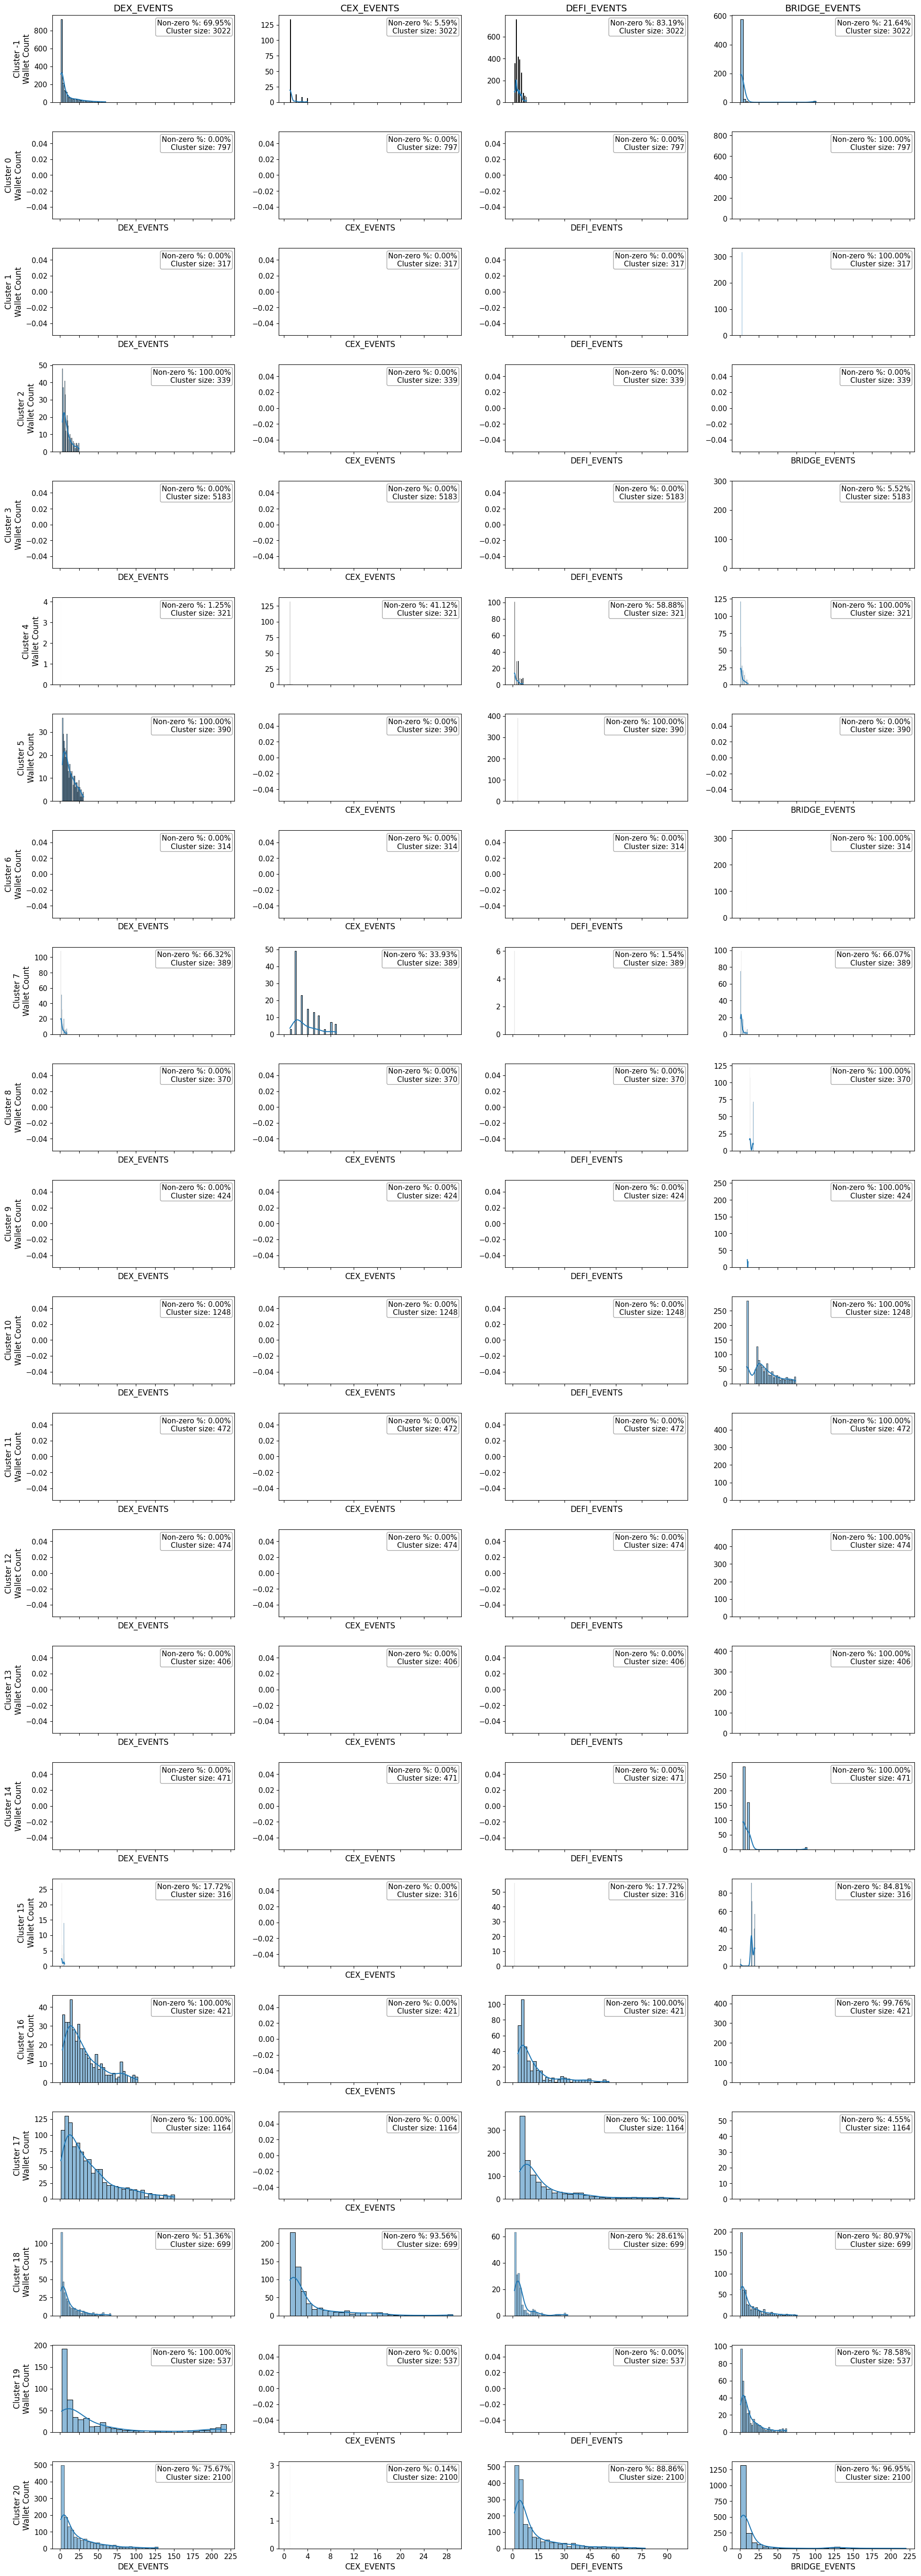

In [96]:
# Plot distribution of all four features for each cluster, using only non-zero values, and display non_zero_proportion and cluster size next to each plot
features = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
clusters = sorted(merged_main['cluster_label'].dropna().unique())
num_clusters = len(clusters)
num_features = len(features)
fig_height = max(4, 2.5 * num_clusters)
fig_width = 5 * num_features
fig, axes = plt.subplots(num_clusters, num_features, figsize=(fig_width, fig_height), sharex='col')
if num_clusters == 1:
    axes = [axes]
for row_idx, cluster in enumerate(clusters):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster]
    cluster_size = len(cluster_df)
    for col_idx, feature in enumerate(features):
        ax = axes[row_idx, col_idx] if num_clusters > 1 else axes[col_idx]
        feature_values = cluster_df[feature].dropna()
        non_zero_values = feature_values[feature_values != 0]
        non_zero_count = len(non_zero_values)
        total_count = len(feature_values)
        non_zero_proportion = non_zero_count / total_count if total_count > 0 else float('nan')
        if len(non_zero_values) > 0:
            p95 = non_zero_values.quantile(0.95)
            plot_values = non_zero_values[non_zero_values <= p95]
        else:
            plot_values = non_zero_values
        sns.histplot(plot_values, bins=30, kde=True, ax=ax)
        # Set consistent x-axis label and formatting
        ax.set_xlabel(feature, fontsize=12)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=False, prune=None))
        ax.ticklabel_format(style='plain', axis='x')
        ax.tick_params(axis='both', which='major', labelsize=11)
        # Set title for each column
        if row_idx == 0:
            ax.set_title(f'{feature}', fontsize=14)
        # Set y-axis label for each row
        if col_idx == 0:
            ax.set_ylabel(f'Cluster {cluster}\nWallet Count', fontsize=12)
        else:
            ax.set_ylabel('')
        # Annotate non_zero_proportion and cluster size next to the plot
        annotation = f'Non-zero %: {non_zero_proportion:.2%}\nCluster size: {cluster_size}'
        ax.text(0.98, 0.95, annotation,
                transform=ax.transAxes, fontsize=11, va='top', ha='right',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', alpha=0.7))
plt.tight_layout(pad=2)
plt.show()